# open FIA data points

In [1]:
# Mostly-standard imports
import os
import sys 
sys.path.append('/content')
import xarray as xr
import tempfile
import numpy as np
import shutil
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from glob import glob
import utm

import src.azuretools as azt

#from mpl_toolkits.basemap import Basemap

# Less-common-but-still-pip-installable imports
from netCDF4 import Dataset

# pip install progressbar2, not progressbar
import progressbar


# This will contain just the .nc files
nasadem_file_list = None
                                   
temp_dir = os.path.join(tempfile.gettempdir(),'nasadem')
os.makedirs(temp_dir,exist_ok=True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
blob = '/home/datablob'
fiafile = f'{blob}/fia_no_pltcn.csv'
plots = gpd.GeoDataFrame(pd.read_csv(fiafile))
plots.Latitude = plots.LAT.astype('float')
plots.Longitude = plots.LON.astype('float')
geometry = [Point(xy) for xy in zip(plots.Longitude, plots.Latitude)]
crs = {'init': 'epsg:4326'} 
geo_df = gpd.GeoDataFrame(plots, crs=crs, geometry=geometry)

#subset by STATECD
statecd = pd.read_csv(glob(f'{blob}/supp_data/*.csv')[0])
query = 'CA'

code = statecd[statecd['STATEAB']== query]['STATECD'].values[0]
subdf = geo_df[geo_df['STATECD']==code]
fields = ['INDEX', 'INVYR', 'LAT', 'LON']
subdf = subdf.astype({'LAT':'float', 'LON':'float', 'INVYR':'int32'})
subdf = gpd.GeoDataFrame(subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))
subdf = subdf.set_crs(epsg=4326)
subdf = subdf.rename(columns={'Unnamed: 0':'INDEX'})

#statebounds for reducing query on cloud
statebounds = glob(f'{blob}/supp_data/shp/*.shp')[0]
states = gpd.read_file(statebounds)
state = states[states['STPOSTAL']==query]
state_shape = state.geometry

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)
/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
!pip3 install azure-storage-blob

     |████████████████████████████████| 326 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 122 kB 47.1 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 3.5 MB/s  eta 0:00:01


In [6]:
# Standard or standard-ish imports
import os
import tempfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Less standard, but still pip- or conda-installable
import netCDF4 as nc 
from azure.storage.blob import ContainerClient
from netCDF4 import Dataset

container_name = 'daymetv3-raw'
daymet_azure_storage_url = 'https://daymet.blob.core.windows.net/'

daymet_container_client = ContainerClient(account_url=daymet_azure_storage_url, 
                                         container_name=container_name,
                                         credential=None)

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(),'daymet')
os.makedirs(temp_dir,exist_ok=True)

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('.', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url)))
        return destination_filename
    print('Downloading file {}'.format(os.path.basename(url)),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [7]:
# pick region
regions = ['na', 'hawaii', 'puertorico']

state_of_interest = regions[0]
year_of_interest = '2010'

# List the blobs in the container
generator = daymet_container_client.list_blobs()
for blob in generator:
    if state_of_interest in blob.name and year_of_interest in blob.name:
        print('Blob name: ' + blob.name)

Blob name: daymet_v3_dayl_2010_na.nc4
Blob name: daymet_v3_prcp_2010_na.nc4
Blob name: daymet_v3_srad_2010_na.nc4
Blob name: daymet_v3_swe_2010_na.nc4
Blob name: daymet_v3_tmax_2010_na.nc4
Blob name: daymet_v3_tmin_2010_na.nc4
Blob name: daymet_v3_vp_2010_na.nc4


In [ ]:
%%time
variable = 'tmax'
year = '2016'

years = np.arange(1980,1982)
for year in years:
    # Choose your location.  The following are available: hawaii, na, puertorico.  The value 'na' stands for North America.
    location = regions[0]

    granule_name = f'daymet_v3_{variable}_{year}_{location}.nc4'
    url = 'https://daymet.blob.core.windows.net/daymetv3-raw/' + granule_name

    filename = download_url(url)

In [289]:
'''
run this if you are hoping to build your URL list
'''
url_list = []
for i,s in subdf.iterrows():
    tile_of_interest = [s['geometry'].y,s['geometry'].x]
    tile_name = lat_lon_to_nasadem_tile(tile_of_interest[0],tile_of_interest[1])
    url = azt.nasadem_blob_root + tile_name
    url_list.append(url)
subdf['DEM_URL'] = url_list

# selecting by number of cells

In [301]:
'''
if we want to select by number of cells around the center point
'''
cell_buffer = 10
if not os.path.exists(f'{blob}/training_tiles/NASADEM/{query}'):
    os.makedirs(f'{blob}/training_tiles/NASADEM/{query}')
    
for sample_index in range(len(subdf)):
    sample_point = gpd.GeoDataFrame(subdf.iloc[sample_index]).T
    sample_point.crs = {'init':'epsg:4269'}
    tile_of_interest = [sample_point.geometry.y.values[0], sample_point.geometry.x.values[0]]
    tile_name = azt.lat_lon_to_nasadem_tile(tile_of_interest[0],\
                                            tile_of_interest[1],\
                                            nasadem_file_list)
    url = azt.nasadem_blob_root + tile_name
    fn = azt.download_url(url,progress_updater = azt.DownloadProgressBar())
    fh = xr.open_dataset(fn, engine='h5netcdf')
    yi = np.argmin(np.abs(fh.lat - float(sample_point['LAT'])).values)
    xi = np.argmin(np.abs(fh.lon - float(sample_point['LON'])).values)
    #set the area around those point defined as c
    data_chunk = fh.isel(lat=slice(yi-cell_buffer,yi+cell_buffer),\
                       lon=slice(xi-cell_buffer,xi+cell_buffer))
    
    
    outfilename = f'{blob}/training_tiles/NASADEM/{query}/{sample_point.INDEX.values[0]}.nc'
    data_chunk.to_netcdf(outfilename)

 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 13% (3620864 of 26000267) |#            | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 37% (9879552 of 26000267) |####         | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 21% (5595136 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 32% (8560640 of 26000267) |####         | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 22% (5931008 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 18% (4939776 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 41% (10862592 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 30% (7905280 of 26000267) |###          | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 43% (11190272 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 39% (10207232 of 26000267) |####        | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 20% (5267456 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 25% (6586368 of 26000267) |###          | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 32% (8560640 of 26000267) |####         | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


# selecting by distance

In [301]:
'''
if we want to select by distance around center point
'''
if not os.path.exists(f'{blob}/training_tiles/NASADEM/{query}'):
    os.makedirs(f'{blob}/training_tiles/NASADEM/{query}')
    
#given we know the utm values can we go look around 1km?
buffer_dist = 500 #500 meters both sides of the center for 1km image

for sample_index in range(len(subdf)):
    sample_point = gpd.GeoDataFrame(subdf.iloc[sample_index]).T
    sample_point.crs = {'init':'epsg:4269'}
    tile_of_interest = [sample_point.geometry.y.values[0], sample_point.geometry.x.values[0]]
    tile_name = azt.lat_lon_to_nasadem_tile(tile_of_interest[0],\
                                            tile_of_interest[1],\
                                            nasadem_file_list)
    url = azt.nasadem_blob_root + tile_name
    fn = azt.download_url(url,progress_updater = azt.DownloadProgressBar())
    fh = xr.open_dataset(fn, engine='h5netcdf')
    
    e_utm_values, n_utm_values, zone, hemi = utm.from_latlon(latitude=float(sample_point.geometry.y), \
                                                         longitude=float(sample_point.geometry.x))
    bounds = {'miny':n_utm_values-buffer_dist, \
              'maxy':n_utm_values+buffer_dist, \
              'minx':e_utm_values-buffer_dist, \
              'maxx':e_utm_values+buffer_dist}
    
    bbox = {'lowerleft':(bounds['miny'], bounds['minx'], zone, hemi),\
            'upperleft':(bounds['maxy'], bounds['minx'], zone, hemi),\
            'upperright':(bounds['maxy'], bounds['maxx'], zone, hemi),\
            'lowerright':(bounds['miny'], bounds['maxx'], zone, hemi)}
    #transform bounds to lat lon
    
    bbox_latlon = {k:utm.to_latlon(v[1], v[0], zone_number=v[2], zone_letter=v[3]) for k,v in bbox.items()}
    minx, maxx, miny, maxy = bbox_latlon['lowerleft'][1],bbox_latlon['lowerright'][1],\
                            bbox_latlon['lowerleft'][0],bbox_latlon['upperright'][0]
    minyi = np.argmin(np.abs(fh.lat - miny).values)
    maxyi = np.argmin(np.abs(fh.lat - maxy).values)
    minxi = np.argmin(np.abs(fh.lon - minx).values)
    maxxi = np.argmin(np.abs(fh.lon - maxx).values)


    #set the area around those point defined as c
    data_chunk = fh.isel(lat=slice(maxyi, minyi),\
                   lon=slice(minxi, maxxi))

    
    
    outfilename = f'{blob}/training_tiles/NASADEM/{query}/{sample_point.INDEX.values[0]}.nc'
    data_chunk.to_netcdf(outfilename)

 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 13% (3620864 of 26000267) |#            | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 37% (9879552 of 26000267) |####         | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 21% (5595136 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 32% (8560640 of 26000267) |####         | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 22% (5931008 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 18% (4939776 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 41% (10862592 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 30% (7905280 of 26000267) |###          | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 43% (11190272 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 39% (10207232 of 26000267) |####        | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

...done, 26000267 bytes.

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 20% (5267456 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 25% (6586368 of 26000267) |###          | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 32% (8560640 of 26000267) |####         | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 49% (12836864 of 26000267) |#####       | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


 16% (4284416 of 26000267) |##           | Elapsed Time: 0:00:00 ETA:  00:00:00

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


N/A% (0 of 26000267) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--

100% (26000267 of 26000267) |############| Elapsed Time: 0:00:00 Time:  0:00:00


...done, 26000267 bytes.


Height ranges from <xarray.DataArray 'NASADEM_HGT' ()>
array(-18., dtype=float32) meters to <xarray.DataArray 'NASADEM_HGT' ()>
array(3756., dtype=float32) meters


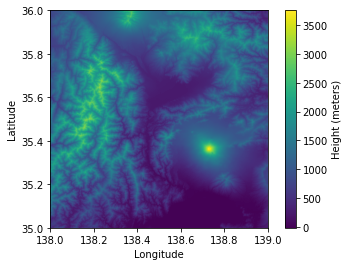

In [11]:
fh = xr.open_dataset(fn, engine='h5netcdf')
heights = fh['NASADEM_HGT'][:]
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]

min_height = np.min(heights)
max_height = np.max(heights)
height_units = fh['NASADEM_HGT'].units

fh.close()

print('Height ranges from {} {} to {} {}'.format(min_height,height_units,
      max_height,height_units))

extent = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
plt.imshow(heights,extent=extent)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cb = plt.colorbar()
cb.set_label('Height ({})'.format(height_units))